In [11]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct
from scipy.integrate import solve_ivp
import scipy as sp

from HJK.dynamics.systems import simple2Dsystem
from HJK.basis.monomials import monomials
from HJK.optimizers.optimizers import cvx, casadi
from HJK.eigfun.eigfun import monomial_eigfun

## Define the system dynamics

### Plot free response of the system

In [12]:
t_span = [0, 10]
x0 = np.array([1, 1])
t = np.linspace(0, 10, 1000)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

params = {"mu":0.5, "lam":-10.0}

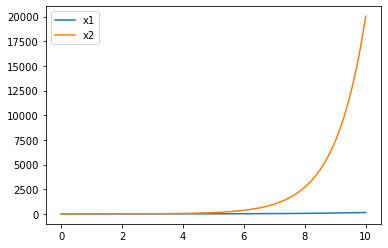

In [13]:
u = 0
sol = solve_ivp(simple2Dsystem, t_span, x0, t_eval=t, args = (u, params))
t = sol.t
y = sol.y

# Plot the response
plt.figure(1)
plt.plot(t, y[0])
plt.plot(t, y[1])
plt.legend(['x1', 'x2'])
plt.show(block=False)

### Linearize the system

In [14]:
A = np.array([[params.get('mu'), 0],[0, params.get('lam')]])
B = np.array([[1],[1]])

## Collect random datapoints from a domain

In [15]:
domain = 5
dim = 2
numIC = 1000
np.random.seed(1)
X = np.random.uniform(low=-domain, high=domain, size=(dim,numIC)).astype(float) 

## Generate basis functions
Monomials from d3s github

In [16]:
degree = 2
d3s_monomials = monomials(degree)
d3s_monomials.display(np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0]),2)

1.000001 + 1.00000 x_1 + 1.00000 x_2 + 1.00000 x_1^2 + 1.00000 x_1 x_2 + 1.00000 x_2^2


In [17]:
Psi = d3s_monomials(X)
DPsi = d3s_monomials.diff(X)

# remove 1 and linear parts
Psi = Psi[dim+1:,:]
DPsi = DPsi[dim+1:,:]

# get length of Psi to determine coefficient U dimensions
Nbs = np.shape(Psi)[0]

## Setup Optimization problem

### Using CVXpy

In [18]:
U = cvx(simple2Dsystem, params, A, X, Psi , DPsi)

Found a feasible x in R^2 that has 1 nonzeros.
optimal objective value: 4.455324267447211e-12
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-9.09090909e-01 -3.12765624e-19  2.01586570e-18]]


In [19]:
Phi, DPhi = monomial_eigfun(X, A, U, degree)

### Using CasADi

In [20]:
U = casadi(dim, Nbs, A, X, simple2Dsystem, params, Psi , DPsi)

RuntimeError: D:\bld\casadi_1647512547064\work\casadi\core\function_internal.cpp:145: Error calling IpoptInterface::init for 'F':
D:\bld\casadi_1647512547064\work\casadi\core\nlpsol.cpp:398: Assertion "sparsity_out_.at(NLPSOL_X).is_dense() && sparsity_out_.at(NLPSOL_X).is_vector()" failed:
Expected a dense vector 'x', but got 2x3,0nz.